# WeRateDogs Twitter 

---

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#question">Questions</a></li>    
<li><a href="#gathering">Data Gathering</a></li>
<li><a href="#assessing">Data Assessment</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#analyzevisualize">Data Analysis and Visualisations</a></li>
<li><a href="#report">Final Report</a></li>
</ul>

---

<a id='intro'></a>
## Introduction

The dataset that is used in this work is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.


The goal is to create interesting and trustworthy analysis and visualizations. Here is a list of activities that are going to be performed here: 
* Gathering data from 3 different sources (abbreviation used DF1, DF2, DF3).
* Assessing data to identify quality and tidiness issues. 
* Cleaning data, that includes activities: definition, coding, testing. 
* Storing, analysing, and visualising interesting insights.
* Reporting on wrangling and data analysis efforts. 

---

<a id='question'></a>
## Questions

The goal is to create interesting and trustworthy analysis and visualizations and search for the answers that could answer the following questions:
* **What are the outcomes of image prediction algorithm?**
* **How did the follower count change over the years?**
* **How did twitting and retweeting likes change over the years?**
* **Which tweet characteristics predict likes and retweeting?**

---

<a id='gathering'></a>
## Data Gathering

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import os
import requests
import json
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import seaborn as sb
import matplotlib.pyplot as plt

### DF1 - Load Image prediction data (tsv format)

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file is hosted on Udacity's servers and is downloaded programmatically using the Requests library and the following [URL](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv).

Dictionary of the attributes:
* p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
* p1_conf is how confident the algorithm is in its #1 prediction → 95%
* p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
* p2 is the algorithm's second most likely prediction → Labrador retriever
* p2_conf is how confident the algorithm is in its #2 prediction → 1%
* p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
etc.

In [2]:
# Create a folder if it's not craeted
folder_name = 'Dataset'
if not os.path.exists(folder_name):
    os.makedirs('Dataset')

In [3]:
# Save link
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [4]:
# Save the content from the saved link
with open(os.path.join(folder_name, url.split("/")[-1]), mode = 'wb') as file:
    file.write(r.content)

In [5]:
# Check Dataset repository
os.listdir(folder_name)

['twitter-archive-enhanced.csv',
 '.DS_Store',
 'image-predictions.tsv',
 'tweet_json.txt']

In [6]:
# Load Image Prediction into Pandas DataFrame
df1=pd.read_csv('Dataset/image-predictions.tsv', sep='\t')
df1.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
847,695409464418041856,https://pbs.twimg.com/media/CaaXN5LUYAEzAh-.jpg,1,pug,0.997445,True,bull_mastiff,0.001749,True,Pekinese,0.000304,True
1255,748346686624440324,https://pbs.twimg.com/media/CmKpVtlWAAEnyHm.jpg,1,borzoi,0.596455,True,whippet,0.231428,True,Saluki,0.058261,True
413,673956914389192708,https://pbs.twimg.com/media/CVpgPGwWoAEV7gG.jpg,1,pug,0.586161,True,Brabancon_griffon,0.082744,True,Chihuahua,0.045878,True
1952,863553081350529029,https://pbs.twimg.com/ext_tw_video_thumb/86355...,1,Eskimo_dog,0.413330,True,malamute,0.347646,True,Siberian_husky,0.149536,True
1152,732585889486888962,https://pbs.twimg.com/media/Ciqq-VFUUAANlWm.jpg,2,Staffordshire_bullterrier,0.843359,True,American_Staffordshire_terrier,0.028290,True,miniature_pinscher,0.016793,True


### DF2 - Load Twitter Archive data (csv format)

The WeRateDogs Twitter archive data file is given, therefore I'm downloading file manually and uploading into the pandas DataFrame.

In [7]:
df2=pd.read_csv('Dataset/twitter-archive-enhanced.csv')
df2.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1245,711732680602345472,NaN,NaN,2016-03-21 01:54:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I want to hear the joke this dog was just told...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711732680...,10,10,None,None,None,None,None


### DF3 - Load Twitter API data (json format)

Using the tweet IDs in the WeRateDogs Twitter archive, I'm query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

Additional information: [pandas API reference](https://pandas.pydata.org/pandas-docs/stable/api.html) for detailed usage information.

#### Query via API and save respond to txt

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df2.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('Dataset/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet_json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

#### Read API data line by line

Here we read the txt file line by line and store values into a list object. 

In [8]:
# Read line by line and save into a list
count=0
tweets_data = []
inputfile=open('Dataset/tweet_json.txt', "r")
for line in inputfile:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except: 
        count+=1
        continue
print('Failed:{}'.format(count))

Failed:0


#### Check json structure
Pandas DataFrame function allows me to load the list object and to have a quick overview of the data structure and data types. 
However this data load approach does not comply with the data tidiness requirements, that are :
* Each variable forms a column
* Each observation forms a row
* Each observational unit forms a table

In [9]:
review=pd.DataFrame(tweets_data)

In [10]:
# Have an overview of data structure and data types
review.head(2)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [11]:
# An overview of a specific variable
review.entities[0]

{'hashtags': [],
 'symbols': [],
 'user_mentions': [],
 'urls': [],
 'media': [{'id': 892420639486877696,
   'id_str': '892420639486877696',
   'indices': [86, 109],
   'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'url': 'https://t.co/MgUWQ76dJU',
   'display_url': 'pic.twitter.com/MgUWQ76dJU',
   'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   'type': 'photo',
   'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'small': {'w': 540, 'h': 528, 'resize': 'fit'},
    'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}

#### Select the attributes and save into DF3

Here I'm specifying the attributes of my interest and loading into pandas DataFrame.

In [12]:
# Had to add a dummy dictionary for the empty list, so that I could grab Hashtags when it has a value.
for tweet in tweets_data:
    if tweet['entities']['hashtags'] == []:
        tweet['entities']['hashtags'] = [{'text': '', 'indices':[]}]

In [13]:
# Grab the specified attributes and load into pandas DataFrame
d = []
for tweet in tweets_data:
    d.append({
        'tweet_id': tweet['id'],
        'tweet_favourite_count' : tweet['favorite_count'],
        'tweet_hashtags' : tweet['entities']['hashtags'][0]['text'],
        'retweet_count' : tweet['retweet_count'],
        'retweeted' : tweet['retweeted'],
        'user_id': tweet['user']['id'],
        'user_followers_count': tweet['user']['followers_count'],
        'user_friends_count': tweet['user']['friends_count'],
        'user_listed_count': tweet['user']['listed_count'],
        'user_favourites_count': tweet['user']['favourites_count'],
        'user_statuses_count': tweet['user']['statuses_count'],
    })

df3=pd.DataFrame(d)
df3.head(2)

,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,tweet_id,user_favourites_count,user_followers_count,user_friends_count,user_id,user_listed_count,user_statuses_count
0,8853,False,39467,,892420643555336193,114031,3200889,104,4196983835,2784,5288
1,6514,False,33819,,892177421306343426,114031,3200889,104,4196983835,2784,5288


### Data Gathering Summary 
> * All 3 data sources are loaded
> * DataFrames are named accorfingly DF1, DF2, DF3. 

---

<a id='assessing'></a>
## Data Assessment

After gathering each of the above pieces of data, requires assessment that is done visually and programmatically. 
There are two types of unclean data concepts:
* **Dirty data**, also known as **low quality data**. Low quality data has **content issues**.
* **Messy data**, also known as **untidy data**. Untidy data has **structural issues**.

Identified quality and tidiness issues are documented in the summaries. 

### DF1 - Image prediction DataFrame

In [14]:
# Assessing data visually
df1.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1785,829374341691346946,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
792,690728923253055490,https://pbs.twimg.com/media/CZX2SxaXEAEcnR6.jpg,1,kuvasz,0.422806,True,golden_retriever,0.291586,True,Great_Pyrenees,0.076189,True
204,669753178989142016,https://pbs.twimg.com/media/CUtw9SAVEAAtFUN.jpg,1,Pembroke,0.858494,True,hamster,0.026319,False,Shetland_sheepdog,0.022405,True


In [15]:
# Assessing data programatically
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
# Counting unique values
df1.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [17]:
# Checking quantitative information
df1.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### Summary for DF1 Assessing :
> **Overview:**
 * At least 75% of the records have only 1 image. 
 * P1 confidence level is very high in comparison with others. 

> **Quality issues:** 
* It could be interested to analyse against the Image format which is currently imbedded in the image link.

>**Tidiness issues:** 
* Prediction columns repeating per each prediction. 

### DF2 - Twitter Archive DataFrame

In [18]:
# Assessing data visually
df2.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1939,673887867907739649,NaN,NaN,2015-12-07 15:32:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're having a great time sleeping and y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673887867...,10,10,None,None,None,None,None
206,852672615818899456,NaN,NaN,2017-04-13 23:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Aspen. She's never tasted a stick so s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/852672615...,12,10,Aspen,None,None,None,None
588,799422933579902976,NaN,NaN,2016-11-18 01:24:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Longfellow (prolly sophisticated). He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/799422933...,12,10,Longfellow,None,None,None,None


In [19]:
# Assessing data programatically
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [20]:
# Counting unique values
df2.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [21]:
# Listing source categories
df2.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [22]:
# Checking quantitative information
df2.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


#### Summary for DF2 Assessing : 
> **Overview:**
 * There are 2356 tweets and tweet_id is unique identificator.
 * There are 4 source categories. 
 * rating_numerator and rating_denominator values have outliers.

> **Quality issues:** 
* Source information is presented by a link. 
* It was mentioned that rating_numerator and rating_denominator values might have arrors.
* It was mentioned that Dogtionary attributes might have have errors. 
* Since I'm interested to have at leats one plot with the timeline I need to have a user friendly date format.

>**Tidiness issues:** 
* Dogtionary types are listed in the columns.

### DF3 - Twitter API DataFrame

In [23]:
# Assessing data visually
df3.sample(3)

,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,tweet_id,user_favourites_count,user_followers_count,user_friends_count,user_id,user_listed_count,user_statuses_count
627,2697,False,11492,,794926597468000259,114031,3200900,104,4196983835,2788,5288
979,1904,False,6721,,749417653287129088,114031,3200943,104,4196983835,2802,5288
2227,523,False,1056,,668248472370458624,114031,3201015,104,4196983835,2812,5288


In [24]:
# Assessing data programatically
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 11 columns):
retweet_count            2354 non-null int64
retweeted                2354 non-null bool
tweet_favourite_count    2354 non-null int64
tweet_hashtags           2354 non-null object
tweet_id                 2354 non-null int64
user_favourites_count    2354 non-null int64
user_followers_count     2354 non-null int64
user_friends_count       2354 non-null int64
user_id                  2354 non-null int64
user_listed_count        2354 non-null int64
user_statuses_count      2354 non-null int64
dtypes: bool(1), int64(9), object(1)
memory usage: 186.3+ KB


In [25]:
# Counting unique values
df3.nunique()

retweet_count            1724
retweeted                   1
tweet_favourite_count    2007
tweet_hashtags             18
tweet_id                 2354
user_favourites_count       2
user_followers_count       66
user_friends_count          1
user_id                     1
user_listed_count          20
user_statuses_count         1
dtype: int64

In [26]:
# Checking quantitative information
df3.describe()

,retweet_count,tweet_favourite_count,tweet_id,user_favourites_count,user_followers_count,user_friends_count,user_id,user_listed_count,user_statuses_count
count,2354.000000,2354.000000,2.354000e+03,2354.000000,2.354000e+03,2354.0,2.354000e+03,2354.000000,2354.0
mean,3164.797366,8080.968564,7.426978e+17,114031.010195,3.200942e+06,104.0,4.196984e+09,2799.480884,5288.0
std,5284.770364,11814.771334,6.852812e+16,0.100478,4.457302e+01,0.0,0.000000e+00,11.178223,0.0
min,0.000000,0.000000,6.660209e+17,114031.000000,3.200799e+06,104.0,4.196984e+09,2724.000000,5288.0
25%,624.500000,1415.000000,6.783975e+17,114031.000000,3.200898e+06,104.0,4.196984e+09,2788.000000,5288.0
50%,1473.500000,3603.500000,7.194596e+17,114031.000000,3.200945e+06,104.0,4.196984e+09,2803.000000,5288.0
75%,3652.000000,10122.250000,7.993058e+17,114031.000000,3.200953e+06,104.0,4.196984e+09,2805.000000,5288.0
max,79515.000000,132810.000000,8.924206e+17,114032.000000,3.201018e+06,104.0,4.196984e+09,2846.000000,5288.0


#### Summary for DF3 Assessing :
> **Quality issues:** 
* Retweet value is always False, which is wrong.  
* user_friends_count and user_statuses_count have always the same value, therefore I'm not interested in this columns.

>**Tidiness issues:** 
* User information should be separated from the Twitter data, since the user is always the same. 

### Check duplicated columns

In [27]:
# Check the column duplicates within all 3 DataFrames
all_columns = pd.Series(list(df1) + list(df2) + list(df3))
all_columns[all_columns.duplicated()]

12    tweet_id
33    tweet_id
dtype: object

---

<a id='cleaning'></a>
## Data Cleaning

The data cleaning activities are performed that includes: 
* Define
* Code
* Test

### Create a working copy

In [28]:
df1_c = df1.copy() # For the Image prediction
df2_c = df2.copy() # For the Archived Twitter
df3_c = df3.copy() # For the Twitter API data

### Join Twitter Archive and Twitter API Data 

#### 1. Join Twitter DataFrames ( Tidiness )

Join both DataFrames on the attribute twitter_id. The Twitter id is a unique record identifier. I'm using inner join type because I'm interested only in the records that are in both DataFrames.

In [29]:
# Code, i.e. join the DataFrames
t_merge = df2_c.merge(df3_c, left_on='tweet_id', right_on='tweet_id')
t_merge = pd.DataFrame(t_merge)

In [30]:
# Test visually
t_merge.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,user_favourites_count,user_followers_count,user_friends_count,user_id,user_listed_count,user_statuses_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,8853,False,39467,,114031,3200889,104,4196983835,2784,5288
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,6514,False,33819,,114031,3200889,104,4196983835,2784,5288
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,4328,False,25461,,114031,3200889,104,4196983835,2784,5288


In [31]:
# Test by counting the records
print('Count of records in Twitter Archive is : {}'.format(df2_c['tweet_id'].count()))
print('Count of records in Twitter API is : {}'.format(df3_c['tweet_id'].count()))
print('Count of records in the merged file is : {}'.format(t_merge['tweet_id'].count()))

Count of records in Twitter Archive is : 2356
Count of records in Twitter API is : 2354
Count of records in the merged file is : 2354


#### 2. Create a new attribute to indicate twitter Year and Month ( Quality )
I have the intention to use timeline information in the visualisation, therefore I need to create a date format that is more user-friendly. The lowest granularity I'm interested in is the month. 

By using a regular expression, I'm going to extract year and month information from the timestamp.

In [32]:
# Code: Change timestamp to string format, then split the string by " " and "-", 
#  eventually concatinate back with '.' and change format to float so that it could be sortable.

date = t_merge['timestamp'].astype(str)
date = date.str.split(' ').str[0].str.split('-').str[:2]
t_merge['date'] = (date.str[0] + '.' + date.str[1]).astype(float)

In [33]:
# Test visually
t_merge['date'].unique()

array([2017.08, 2017.07, 2017.06, 2017.05, 2017.04, 2017.03, 2017.02,
       2017.01, 2016.12, 2016.11, 2016.1 , 2016.09, 2016.08, 2016.07,
       2016.06, 2016.05, 2016.04, 2016.03, 2016.02, 2016.01, 2015.12,
       2015.11])

### Clean Image Prediction File

#### 1. Add image format ( Quality )

From the jpg_url I want to extract the image format and save it into a separate column. By using a regular expression, I'm going to split the string and grab the last value. 

In [34]:
# A code to extract image format
df1_c['im_type'] = df1_c['jpg_url'].str.split(".").str[-1]

In [35]:
# Check unique image formats
df1_c['im_type'].unique()

array(['jpg', 'png'], dtype=object)

#### 2. Transform the columns ( Tidiness )
Prediction columns as p(x), p(x)_conf, p(x)_dog; should be merged and a new column with prediction algorithm No. should be added. 


First, I am creating 3 separate data frames with new column prd and defaulted values p1, p2, or p3. Then,  I'm concatenating into a single DataFrame.

In [36]:
df1_c.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,im_type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,jpg
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,jpg
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,jpg


In [37]:
# Create a dataframe for prediction 1
prd1 = pd.DataFrame(df1_c, columns=['tweet_id','img_num', 'im_type', 'p1', 'p1_conf', 'p1_dog'])
prd1['prd']='p1'
prd1 = prd1.rename(columns={'tweet_id':'tweet_id','img_num':'img_num', 'im_type':'im_type', 
                            'prd':'prd', 'p1':'guess', 'p1_conf':'conf', 'p1_dog':'dog'})

In [38]:
# Test visually
prd1.sample(3)

,tweet_id,img_num,im_type,guess,conf,dog,prd
259,670782429121134593,1,jpg,Chihuahua,0.952963,True,p1
1644,808106460588765185,1,jpg,golden_retriever,0.426183,True,p1
1568,794332329137291264,1,jpg,Samoyed,0.988307,True,p1


In [39]:
# Create a dataframe for prediction 2
prd2 = pd.DataFrame(df1_c, columns=['tweet_id','img_num', 'im_type', 'p2', 'p2_conf', 'p2_dog'])
prd2['prd']='p2'
prd2 = prd2.rename(columns={'tweet_id':'tweet_id','img_num':'img_num', 'im_type':'im_type', 
                            'prd':'prd', 'p2':'guess', 'p2_conf':'conf', 'p2_dog':'dog'})

In [40]:
# Test visually
prd2.sample(3)

,tweet_id,img_num,im_type,guess,conf,dog,prd
1224,744971049620602880,1,jpg,golden_retriever,0.282017,True,p2
339,672245253877968896,1,jpg,badger,0.178546,False,p2
1699,816829038950027264,1,jpg,golden_retriever,0.245773,True,p2


In [41]:
# Create a dataframe for prediction 3
prd3 = pd.DataFrame(df1_c, columns=['tweet_id','img_num', 'im_type', 'p3', 'p3_conf', 'p3_dog'])
prd3['prd']='p3'
prd3 = prd3.rename(columns={'tweet_id':'tweet_id','img_num':'img_num', 'im_type':'im_type', 
                            'prd':'prd', 'p3':'guess', 'p3_conf':'conf', 'p3_dog':'dog'})

In [42]:
# Test visually
prd3.sample(3)

,tweet_id,img_num,im_type,guess,conf,dog,prd
1336,758355060040593408,1,jpg,Siamese_cat,0.000117,False,p3
962,705970349788291072,1,jpg,chow,0.036953,True,p3
1832,836677758902222849,2,jpg,snow_leopard,0.079694,False,p3


In [43]:
# Concatinate all 3 DataFrames with a new attribute "prd" indicating whether it's the prediction 1, 2, or 3
frames = [prd1, prd2, prd3]
prediction_clean=pd.concat(frames)

In [44]:
# Check the results
prediction_clean.sample(5)

,tweet_id,img_num,im_type,guess,conf,dog,prd
695,684460069371654144,1,jpg,Chesapeake_Bay_retriever,0.194897,True,p2
1337,758405701903519748,4,jpg,Chesapeake_Bay_retriever,0.702954,True,p1
393,673583129559498752,1,jpg,golden_retriever,0.113946,True,p2
1094,719991154352222208,2,jpg,golden_retriever,0.605304,True,p1
1411,770772759874076672,1,jpg,chow,0.979515,True,p1


#### 3. Save the cleaned file

In [45]:
# Create a folder if it's not craeted
folder_name = 'Clean_dataset'
if not os.path.exists(folder_name):
    os.makedirs('Clean_dataset')

In [46]:
# Save into a csv format
df.to_csv(prediction_clean, 'Clean_dataset/prediction_clean.csv', sep=',')

### Create Twitter User DataFrame

#### 1. Create a new DataFrame ( Tidiness & Quality )
I'll grab user attributes and save it into a separate data frame. I'd like to see the followers growth rate. 

In [47]:
# Check the attributes
t_merge.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,retweeted,tweet_favourite_count,tweet_hashtags,user_favourites_count,user_followers_count,user_friends_count,user_id,user_listed_count,user_statuses_count,date
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,39467,,114031,3200889,104,4196983835,2784,5288,2017.08
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,False,33819,,114031,3200889,104,4196983835,2784,5288,2017.08
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,False,25461,,114031,3200889,104,4196983835,2784,5288,2017.07


In [48]:
# Create a new User Dataframe with user information and twitter dates
user=pd.DataFrame(t_merge, columns=['timestamp', 'date','user_favourites_count', 'user_followers_count', 
                                    'user_id', 'user_listed_count'])

In [49]:
# Test visually
user.head(2)

,timestamp,date,user_favourites_count,user_followers_count,user_id,user_listed_count
0,2017-08-01 16:23:56 +0000,2017.08,114031,3200889,4196983835,2784
1,2017-08-01 00:17:27 +0000,2017.08,114031,3200889,4196983835,2784


In [50]:
# Count duplicated records
user.duplicated(['user_favourites_count', 'user_followers_count', 
                 'user_id', 'user_listed_count', 'date']).count()

2354

In [51]:
# Remove duplicates and leave only unique values
user.drop_duplicates(['user_favourites_count', 'user_followers_count', 
                      'user_id', 'user_listed_count', 'date'], inplace=True)

In [52]:
# Count unique user records
user['user_id'].count()

104

In [53]:
# Test visually
user.head(3)

,timestamp,date,user_favourites_count,user_followers_count,user_id,user_listed_count
0,2017-08-01 16:23:56 +0000,2017.08,114031,3200889,4196983835,2784
2,2017-07-31 00:18:03 +0000,2017.07,114031,3200889,4196983835,2784
20,2017-07-19 16:06:48 +0000,2017.07,114031,3200890,4196983835,2784


In [54]:
# Check the insights
print ('The count of followers within {} and {} time period changed by {}%'.format 
       ((user['date'].min()), (user['date'].max()), (round((user['user_followers_count'].max())/(user['user_followers_count'].min())))))

The count of followers within 2015.11 and 2017.08 time period changed by 1.0%


#### 2. Save cleaned User.csv file

In [55]:
# Save into a csv format
df.to_csv(user, 'Clean_dataset/user_clean.csv', sep=',')

### Clean Twitter information

#### 1. Clean dataframe by removing unecessary attributes ( Quality )
I want to reduce the list of attributes and keep only the ones I'm going to clean or use for visualisations. All the other attributes are dropped from this analysis. 

In [56]:
t_merge.shape

(2354, 28)

In [57]:
# Check the attributes and identify the ones to be dropped
t_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 28 columns):
tweet_id                      2354 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2354 non-null object
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           179 non-null float64
retweeted_status_user_id      179 non-null float64
retweeted_status_timestamp    179 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null int64
rating_denominator            2354 non-null int64
name                          2354 non-null object
doggo                         2354 non-null object
floofer                       2354 non-null object
pupper                        2354 non-null object
puppo                         2354 non-null object
retweet_count                 23

In [58]:
# Drop attribute, that I'm not going to use for the analysis
t_merge.drop(columns=['user_favourites_count', 'user_followers_count', 'user_friends_count', 'user_id', 
                      'user_listed_count', 'user_statuses_count', 'in_reply_to_status_id',
                      'in_reply_to_user_id', 'expanded_urls', 'retweeted_status_id', 
                      'retweeted_status_user_id'], inplace = True)

In [59]:
# Test programatically 
t_merge.shape

(2354, 17)

In [60]:
# Test visually
t_merge.head(1)

,tweet_id,timestamp,source,text,retweeted_status_timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,date
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,13,10,Phineas,None,None,None,None,8853,False,39467,,2017.08


#### 2. Extract source name from the link ( Quality )
There are 4 types of sources that are presented by a link. I want to use regular expressions to extract the titles from a link. 

In [61]:
# Check the source values
t_merge.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [62]:
# Code, i.e. split the spring and grab the source name
t_merge['source'] = t_merge['source'].str.split(">").str[1].str.split("<").str[0]

In [63]:
# Test
t_merge['source'].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

#### 3. Clean rating information ( Quality )

As it was described in the description "The **ratings** probably aren't all correct." Rating information is part of the text and always have a format "digit/digit". Here are some examples of the text with the rating in the end, however as you see the same pattern might appear twice in the text. 

In [64]:
print('Text examples: \n * {} or \n * {} or \n * {}'.format(t_merge['text'][2332], t_merge['text'][2333], t_merge['text'][2334]))

Text examples: 
 * This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0 or 
 * This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv or 
 * Can take selfies 11/10 https://t.co/ws2AMaNwPW


I want to check if every record has a text and if there is a nan value in the ratings. 

In [65]:
# Check if all the tweets have a text
print('Count of records with empty text is {}'.format (t_merge['text'].isnull().sum()))
# Check if there are empty ratings
print('Count of records with empty rating is {}/{}'.format ((t_merge['rating_numerator'].isnull().sum()), (t_merge['rating_denominator'].isnull().sum())))

Count of records with empty text is 0
Count of records with empty rating is 0/0


In order to grab the last "digit/digit" pattern in the string, I need to reverse the string, but before this, I'll get rid of the link information that is at the end of the string.

In [66]:
# Code. Remove the link and reverse the string. 
rating = t_merge['text'].str.split('https:').str[0].str[::-1]
# Grap the first pattern 
rating = rating.str.extract('(\d+)/(\d+)')
# Store nto the rating format and do a back reverse
full_rating = (rating[0]+'/'+rating[1])
full_rating = full_rating.str[::-1]

In [67]:
# Test by comparing the ratings
print('Differences in old and new numerator values : {}'.format((t_merge[t_merge['rating_numerator'] != full_rating.str.split('/').str[0].astype(int)]['tweet_id'].count())))
print('Differences in old and new denominator values : {}'.format( (t_merge[t_merge['rating_denominator'] != full_rating.str.split('/').str[1].astype(int)]['tweet_id'].count())))

Differences in old and new numerator values : 32
Differences in old and new denominator values : 7


In [68]:
# Overwrite with the new values
t_merge['rating_numerator']=full_rating.str.split('/').str[0].astype(int)
t_merge['rating_denominator']=full_rating.str.split('/').str[1].astype(int)
t_merge.head(3)

,tweet_id,timestamp,source,text,retweeted_status_timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,date
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,13,10,Phineas,None,None,None,None,8853,False,39467,,2017.08
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,13,10,Tilly,None,None,None,None,6514,False,33819,,2017.08
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,12,10,Archie,None,None,None,None,4328,False,25461,,2017.07


#### 4. Clean Dogtionary information ( Quality )

As it was described in the description "The ratings probably aren't all correct. Same goes for the dog names and **probably dog stages**".

I'm going to scan the text and search if the categories were mentioned in the text, then I store the result in the new columns and do a comparison with the old values. Eventually, old values are replaced by new ones. 

In [69]:
# Code. Scan the text and fill in a boolean if it was mentioned in the text
t_merge['doggo1'] = t_merge['text'].str.contains('doggo')
t_merge['floofer1'] = t_merge['text'].str.contains('floofer')
t_merge['pupper1'] = t_merge['text'].str.contains('pupper')
t_merge['puppo1'] = t_merge['text'].str.contains('puppo')

In [70]:
# Code. Correct value from bollean to the standard ones so that I could do a comparison
t_merge['doggo1'] = t_merge['doggo1'].map({True:'doggo',False:'None'})
t_merge['floofer1'] = t_merge['floofer1'].map({True:'floofer',False:'None'})
t_merge['pupper1'] = t_merge['pupper1'].map({True:'pupper',False:'None'})
t_merge['puppo1'] = t_merge['puppo1'].map({True:'puppo',False:'None'})

In [71]:
# Test by comparing old and new values
print ('Mismatch for doggo : {}'.format(t_merge[t_merge['doggo1'] != t_merge['doggo']]['tweet_id'].count()))
print ('Mismatch for floofer : {}'.format(t_merge[t_merge['floofer1'] != t_merge['floofer']]['tweet_id'].count()))
print ('Mismatch for pupper : {}'.format(t_merge[t_merge['pupper1'] != t_merge['pupper']]['tweet_id'].count()))
print ('Mismatch for puppo : {}'.format(t_merge[t_merge['puppo1'] != t_merge['puppo']]['tweet_id'].count()))

Mismatch for doggo : 19
Mismatch for floofer : 6
Mismatch for pupper : 33
Mismatch for puppo : 9


In [72]:
# Old values are replaced by new ones
t_merge.drop(columns=['doggo','floofer','pupper','puppo'], inplace=True)
t_merge = t_merge.rename(columns={'doggo1':'doggo','floofer1':'floofer', 'pupper1':'pupper', 'puppo1':'puppo'})
t_merge.head(1)

,tweet_id,timestamp,source,text,retweeted_status_timestamp,rating_numerator,rating_denominator,name,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,date,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,13,10,Phineas,8853,False,39467,,2017.08,None,None,None,None


#### 5. Concatinate Dogtionary information into one column ( Tidiness )

I'm going to merge Dogtionary category columns into one column by concatenating the strings. 

In [73]:
# Code. Concatinate strings
t_merge.replace({'doggo':'None','floofer':'None','pupper':'None','puppo':'None'}, "", inplace=True)
t_merge['dogtionary'] = t_merge['doggo'] + " " + t_merge['floofer'] + " " + t_merge['pupper'] + " " + t_merge['puppo']

In [74]:
# check the result
t_merge['dogtionary'].unique()

array(['   ', 'doggo   ', '   puppo', '  pupper ', ' floofer  ',
       'doggo   puppo', 'doggo  pupper '], dtype=object)

In [75]:
# Remove additional spaces and assign np.nan in case of null
t_merge['dogtionary'] = t_merge['dogtionary'].astype(str)
t_merge['dogtionary'] = t_merge['dogtionary'].str.rstrip(' ')
t_merge['dogtionary'] = t_merge['dogtionary'].str.lstrip(' ')

t_merge['dogtionary'] = t_merge['dogtionary'].str.replace (' ',' ')
t_merge['dogtionary'] = t_merge['dogtionary'].str.replace ('  ',' ')
t_merge['dogtionary'] = t_merge['dogtionary'].str.replace ('   ',' ')

t_merge.loc[t_merge['dogtionary'] == '', 'dogtionary'] = np.nan

In [76]:
# Check the results
t_merge['dogtionary'].unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo  puppo',
       'doggo pupper'], dtype=object)

In [77]:
# Drop the columns and test visually
t_merge.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)
t_merge.head(3)

,tweet_id,timestamp,source,text,retweeted_status_timestamp,rating_numerator,rating_denominator,name,retweet_count,retweeted,tweet_favourite_count,tweet_hashtags,date,dogtionary
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,13,10,Phineas,8853,False,39467,,2017.08,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,13,10,Tilly,6514,False,33819,,2017.08,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,12,10,Archie,4328,False,25461,,2017.07,NaN


#### 6. Correct Retweeted value ( Quality )
Retweet information is always False which is incorrect. I'm going to add a logic, if retweet timestamp is not null, then Retweeted value should be True. 

In [78]:
# Check the unique values
t_merge['retweeted'].unique()

array([False])

In [79]:
# Code to replace by True when the timestamp is not na
t_merge['retweeted'] = pd.notna(t_merge['retweeted_status_timestamp'])

In [80]:
# Test programatically
print('Count of retweeted_status_timestamp : {}'.format(t_merge['retweeted_status_timestamp'].count()))
print('Count of retweeted status : {}'.format(t_merge['retweeted'].sum()))

Count of retweeted_status_timestamp : 179
Count of retweeted status : 179


#### 7. Save into a csv format

In [81]:
df.to_csv(t_merge, 'Clean_dataset/twitter_archive_master.csv', sep=',')

### Summary of Data Cliening
> All cleaned files can be found in [Clean_dataset repository](https://github.com/SvajuneK/Udacity-Projects/tree/master/Data%20Analyst%20ND/P3%20%22We%20rate%20Dogs%22%20Analysis/Clean_dataset).

In [82]:
os.listdir('Clean_dataset')

['.DS_Store',
 'prediction_clean.csv',
 'twitter_archive_master.csv',
 'user_clean.csv']

---

<a id='analyzevisualize'></a>
## Data Analysis, and Visualisations

Here I come back to the questions that were raised in the beggining of the work and I'm going to visualise the answers for those questions:
* **What are the outcomes of image prediction algorithm?**
* **How did the follower count change over the years?**
* **How did twitting and retweeting likes change over the years?**
* **Which tweet characteristics predict likes and retweeting?**

### What are the outcomes of image prediction algorithm?

Here I am interested only in those cases when the prediction outcome was a breed of dog.

In [83]:
print('Dog breed success rate is {}%'.format (round(prediction_clean[prediction_clean['dog'] == True]['tweet_id'].count()*100/prediction_clean.shape[0],2)))

Dog breed success rate is 73.64%


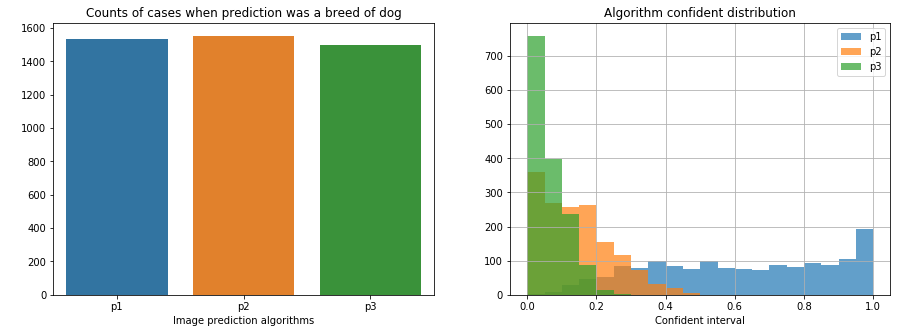

In [84]:
# Create a data set with the predicted breed of a dog is True. 
data=prediction_clean[prediction_clean['dog'] == True]

plt.figure(figsize = [15, 5]) 

plt.subplot(1, 2, 1) 
sb.countplot(data=data, x = 'prd')
plt.title ('Counts of cases when prediction was a breed of dog')
plt.xlabel('Image prediction algorithms');
plt.ylabel(' ');

plt.subplot(1, 2, 2)
color1=sb.color_palette()[0]
color2=sb.color_palette()[1]
color3=sb.color_palette()[2]
bin_edges = np.arange(0, prediction_clean['conf'].max()+0.05, 0.05)
al=0.7
data.query('prd=="p1"')['conf'].hist(label='p1', color=color1, alpha=al, bins=bin_edges);
data.query('prd=="p2"')['conf'].hist(label="p2", color=color2, alpha=al, bins=bin_edges);
data.query('prd=="p3"')['conf'].hist(label="p3", color=color3, alpha=al, bins=bin_edges);
plt.legend()
plt.title('Algorithm confident distribution')
plt.xlabel('Confident interval');

#### Conclusion:
> * Dog breed success rate is 73.64%
> * Success rate distribution per each algoithms is very similar.
> * However the confidence interval for dog breed predictions has a very different distribution.

### How did follower count change over the years? 

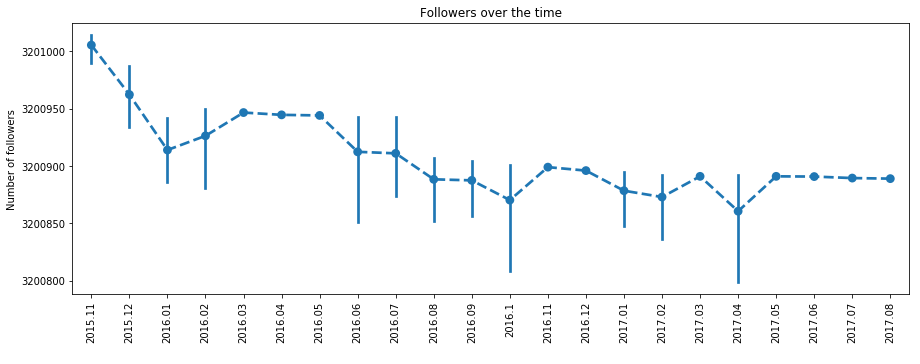

In [89]:
plt.figure(figsize = [15, 5]) 
ax = sb.pointplot(data = user, x = 'date', y = 'user_followers_count', 
                  dodge = 0.6, linestyles = "--", marker = ["o"])
plt.title ('Followers over the time')
plt.xticks(rotation=90)
plt.xlabel(' ')
plt.ylabel('Number of followers');

#### Conclusion:
> * The followers number over the time has decreasing tendencies.

### How did twitting and retweeting likes change over the years?

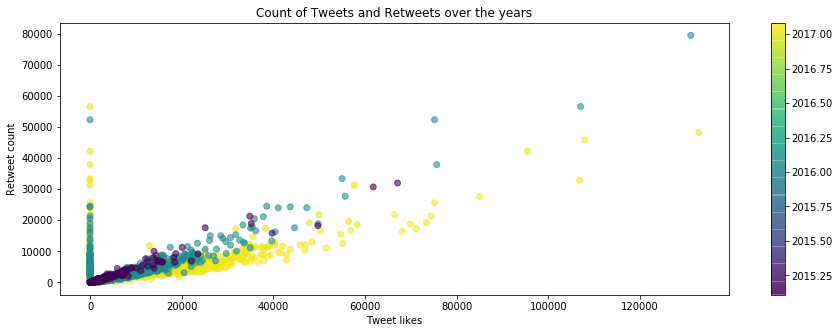

In [86]:
plt.figure(figsize = [15, 5]) 
plt.scatter(data = t_merge, x = 'tweet_favourite_count', y = 'retweet_count',c='date',alpha=0.6)
plt.colorbar()
plt.title ('Count of Tweets and Retweets over the years')
plt.xlabel('Tweet likes')
plt.ylabel('Retweet count');

#### Conclusion: 
> * Despite the reducing of the followers' number, the tweet likes are increasing with the time.
> * However the user behaviour for liking and retweeting is changing slightly. 

### Which tweet characteristics predict likes and retweeting?

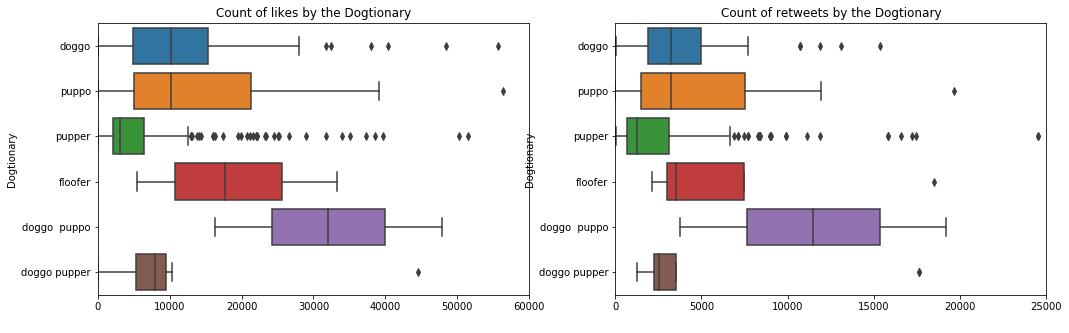

In [106]:
plt.figure(figsize = [17, 5]) 

plt.subplot(1, 2, 1)
sb.boxplot(data = t_merge, y = 'dogtionary', x = 'tweet_favourite_count')
plt.title ('Count of likes by the Dogtionary')
plt.xlabel(' ')
plt.xlim(0, 60000)
plt.ylabel('Dogtionary');


plt.subplot(1, 2, 2)
sb.boxplot(data = t_merge, y = 'dogtionary', x = 'retweet_count')
plt.title ('Count of retweets by the Dogtionary')
plt.xlabel('')
plt.ylabel(' ')
plt.xlim(0, 25000)
plt.ylabel('Dogtionary');

In [88]:
print('Only {}% of the records had dogtionary category.'.format (100-(round(t_merge['dogtionary'].isnull().sum()*100/t_merge['dogtionary'].shape[0]))))


Only 17.0% of the records had dogtionary category.


#### Conclusion:
> * Only 17.0% of the records had a Dogtionary category. 
> * However form those 17& cases you can see a clear correlation within the dogtionary and tweet likes or retweets. "doggo together with puppo are the favourite ones.  

---

<a id='report'></a>
## Final Report

The final reports with the brief descriptions of wrangling efforts and findings can be found [here](https://github.com/SvajuneK/Udacity-Projects/tree/master/Data%20Analyst%20ND/P3%20%22We%20rate%20Dogs%22%20Analysis/Reports).
